# Audio Scene Classification

This notebook guides you through building and training a simple neural network to classify audio scenes. The task is to identify the environment or setting where an audio recording was captured, such as a 'bus', 'cafe', or 'park', based solely on the sounds present in the audio data. You will implement your own classification network to perform this task.


# Import Required Libraries

In [ ]:
# Neural Network Implementation:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim

# Audio and files:
from IPython.display import Audio, display
from pathlib import Path
import os
import random
import importlib

# Graph Plotting:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
%matplotlib inline
from tqdm import tqdm

# Arrays:
import numpy as np

# Matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# GPU (payed for pro if not i could not connect)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import the Audio Data


In [ ]:
# Download the dataset
zip_file_path = "/home/TCD/Lab-06/dataset.zip"
if not os.path.exists(zip_file_path):
    !curl --create-dirs -o {zip_file_path} https://tcddeeplearning.blob.core.windows.net/deeplearning202324/audiosceneclassification2025.zip
else:
    print(f"File already exists: {zip_file_path}")

# Unzip the dataset if the directory doesn't exist
dataset_dir = "/home/TCD/Lab-06/dataset/"
if not os.path.exists(dataset_dir):
    !unzip /home/TCD/Lab-06/dataset.zip -d {dataset_dir}
else:
    print(f"Dataset directory already exists: {dataset_dir}")

File already exists: /home/TCD/Lab-06/dataset.zip
Dataset directory already exists: /home/TCD/Lab-06/dataset/


# Lets Listen to the Data 👂

The lab is composed of 15 possible scenes. The cell below plays a random clip from the training data and shows its label.

Have a listen with headphones, replay the cell to load another random clip.

In [ ]:
# Gets all the audios with its correct matching labels
data_root = "/home/TCD/Lab-06/dataset/small_set_complete/"
meta_filename = "meta.txt"
audio_subdir = "audio"

# File paths:
root = Path(data_root).resolve()
audio_dir = root / audio_subdir
meta_path = root / meta_filename

# Match label to audio clip:
with meta_path.open() as fh:
    meta = {}
    for line in fh:
        rel_path, label, clip_id = line.strip().split("\t")
        meta[rel_path] = {"label": label, "clip_id": clip_id}

# Choose one random audio to print and show label
choices = list(audio_dir.glob("*.wav"))
chosen = random.choice(choices)
rel_from_audio_dir = chosen.relative_to(audio_dir)
meta_key = (Path("audio") / rel_from_audio_dir).as_posix()
info = meta.get(meta_key) or meta.get(chosen.relative_to(root).as_posix())

print(f"Playing: {chosen}")
if info:
    print(f"Label: {info['label']} | Clip: {info['clip_id']}")
else:
    print("No metadata found for this file.")

display(Audio(filename=str(chosen)))

Playing: /home/TCD/Lab-06/dataset/small_set_complete/audio/a101_90_100.wav
Label: car | Clip: a101


# Mount your drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


# Tasks
1. Implement the Dataset Class in `audio_dataset.py`
2. Implement your audio classification model in `models.py`
3. Save your model to the root of the directory as `model.pth`. [*DO NOT CHANGE THE NAME*]

We have provided instructions in each file.

Do not change the file or class names.

In [ ]:
# Run this cell to reload the LoadAudio or AudioClassifier if you have modified after the first attempt
import models, audio_dataset          # import the modules themselves
importlib.reload(models)
importlib.reload(audio_dataset)

from models import AudioClassifier    # now import the names you need
from audio_dataset import LoadAudio

# Unit Test of Dataset and Model
In the cell below, we check your dataset and model inputs, outputs and variables are as we expect them.

If you fail any of these tests, your model or dataset will be rejected by the testing server.

In [ ]:
# Check file exists
data_root = "/home/TCD/Lab-06/dataset/small_set_complete"
audio_subdir = "audio"
meta_filename = "meta.txt"

print("Root:", os.path.exists(data_root))
print("Audio dir:", os.path.exists(os.path.join(data_root, audio_subdir)))
print("Meta:", os.path.exists(os.path.join(data_root, meta_filename)))

# List some audio files:
print("Audio files:", list(Path(data_root, audio_subdir).glob("*.wav"))[:5])


Root: True
Audio dir: True
Meta: True
Audio files: [PosixPath('/home/TCD/Lab-06/dataset/small_set_complete/audio/a073_81_91.wav'), PosixPath('/home/TCD/Lab-06/dataset/small_set_complete/audio/a030_160_170.wav'), PosixPath('/home/TCD/Lab-06/dataset/small_set_complete/audio/b051_90_100.wav'), PosixPath('/home/TCD/Lab-06/dataset/small_set_complete/audio/a124_270_280.wav'), PosixPath('/home/TCD/Lab-06/dataset/small_set_complete/audio/b088_60_70.wav')]


In [ ]:
# Tests to check everything within requirements

from function_test import test_dataset, print_model_summary, test_model_forward

# Immutable dataset args for evaluation
data_root = "/home/TCD/Lab-06/dataset/small_set_complete"
meta_filename = "meta.txt"
audio_subdir = "audio"

# 1) Dataset tests
ds_ok, dataset, loader = test_dataset(
    LoadAudioClass=LoadAudio,
    root_dir=data_root,
    meta_filename=meta_filename,
    audio_subdir=audio_subdir,
    torch=torch,
    DataLoader=DataLoader,
    batch_size=1
)

# 2) Model summary & param budget
num_classes = getattr(dataset, "num_classes", 15)
model = AudioClassifier(num_classes=num_classes).to(device)
ms_ok = print_model_summary(model, summary, feature_example_shape=(1, 220500), max_params=5_000_000)

# 3) Model forward tests
mf_ok = test_model_forward(model, loader, torch, device=device, num_classes=num_classes)

print("\n=== Overall ===")
print("ALL TESTS PASSED ✅" if (ds_ok and ms_ok and mf_ok) else "SOME TESTS FAILED ❌")


=== Dataset Tester ===
Dataset instantiation: OK
Number of samples: 600
Possible classes (15): ['beach', 'bus', 'cafe/restaurant', 'car', 'city_center', 'forest_path', 'grocery_store', 'home', 'library', 'metro_station', 'office', 'park', 'residential_area', 'train', 'tram']
Class order matches reference list: OK

Iterating 5 minibatches (feature shapes):
  Batch 1:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)


/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


  Batch 2:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 3:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 4:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 5:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)

Dataset tests: PASSED ✅

=== Model Summary ===
Summary unavailable (skipping): Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 2, 1, 220500] to have 1 channels, but got 2 channels instead
Trainable parameters: 423631
Parameter budget: OK ✅

=== Model Forward Tester ===
Feature 0 shape: (1, 1, 128, 431)
Labels shape: (1,)
Model output shape: (1, 15)
Per-class logits (sample 0):
  Class 0: -0.1731
  Class 1: -0.0762
  Class 2: -0.5668
  Class 3: -0.5846
  Class 4: 0.7578
  Class 5: 0.0799
  Class 6: 0.1403
  Class 7: 0.0725
  Class 8: 0.1373
  Class 9: -0.0817
  Class 10: -0.0756
  Class 11: 0.1104
  Class 12: -0.3396
  Class 13: 0.1155
  Class 14: -0.4190
Model forward check: OK ✅

=== Overall ===
A

# Train your model
Call your dataset, optimizers, scheduelers, implement training and validation dataloaders. Write your training loop.

In [ ]:
# Custom callback for plotting loss and accuracy during training
class PlotLogAccuracy:

  def __init__(self):
    self.epochs = []
    self.train_losses = []
    self.val_losses = []
    self.train_acc = []
    self.val_acc = []
    self.epoch_count = 0

  def update(self, train_loss, train_acc, val_loss, val_acc):
    self.epochs.append(self.epoch_count)
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_count += 1
    clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(self.epochs, self.train_losses, label="train loss")
    plt.plot(self.epochs, self.val_losses, label="validation loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(self.epochs, self.train_acc, label="training accuracy")
    plt.plot(self.epochs, self.val_acc, label="validation accuracy")
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show();

In [ ]:
# Loading Dataset:
dataset = LoadAudio(
    root_dir="/home/TCD/Lab-06/dataset/small_set_complete",
    meta_filename="meta.txt",
    audio_subdir="audio",
    training_flag=True
)

# Split dataset: 80% train, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create Dataloaders (mini-batches)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Total samples: 600
Training samples: 480
Validation samples: 120


In [ ]:
# Model loss, optimizer, scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = dataset.num_classes
plotter = PlotLogAccuracy()

model = AudioClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Half learning rate

print('Setup complete.')

Setup complete.


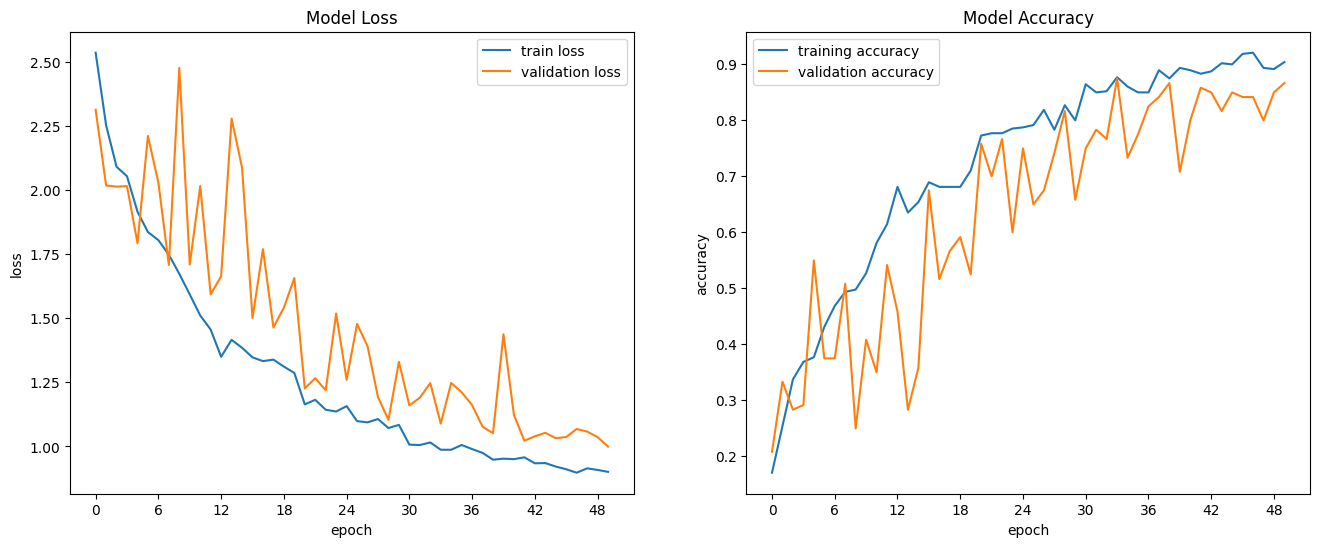

Epochs: 100%|██████████| 50/50 [10:35<00:00, 12.72s/it]

Epoch 50: Train Loss 0.9009 Acc 0.9042 | Val Loss 0.9995 Acc 0.8667
Training finished.


In [ ]:
# Training
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0  # For saving the best model

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    # Training:
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for waveforms, labels in train_loader:
        waveforms = waveforms.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(waveforms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * waveforms.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation:
    model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    with torch.no_grad():
        for waveforms, labels in val_loader:
            waveforms = waveforms.to(device)
            labels = labels.to(device)

            outputs = model(waveforms)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * waveforms.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            # Per-class accuracy
            for label in range(num_classes):
                mask = labels == label
                class_total[label] += mask.sum().item()
                class_correct[label] += (preds[mask] == label).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Step the scheduler
    scheduler.step()

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # At the end of the epoch, plot loss and accuracy for training/validation
    plotter.update(train_loss, train_acc, val_loss, val_acc)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}')
print('Training finished.')


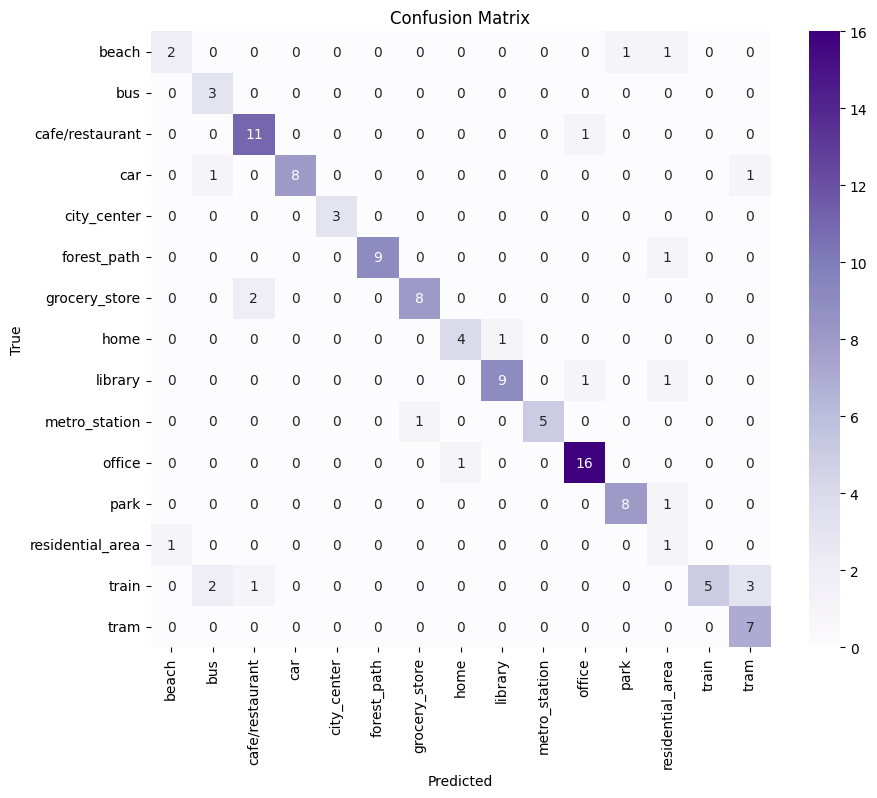

In [ ]:
# Collect all predictions and labels
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for waveforms, labels in val_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)
        outputs = model(waveforms)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=dataset.class_names,
            yticklabels=dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
MODEL_PATH = 'model.pth'  # DO NOT CHANGE THE NAME, this is required by the evaluation script
# Save the entire model
torch.save(model, os.path.join('/content/gdrive/MyDrive/4c16-labs/code/lab-06', MODEL_PATH))
print('Model saved to', MODEL_PATH)

Model saved to model.pth




## Data Preprocessing and Feature Engineering
*   **Spectrograms:** Convert audio signals into spectrograms (time-frequency representations). These can be treated as images and processed using Convolutional Neural Networks (CNNs) designed for 2D data.

*   **Mel-Scale Frequency Cepstral Coefficients (MFCCs):** Instead of using raw audio waveforms, consider extracting more informative features like MFCCs. The human ear perceives frequencies on a non-linear scale (mel scale). MFCCs capture the spectral envelope of the sound, which is more relevant for human perception and often leads to better performance in audio tasks.
